# ANN (5,12,1) Python Code
## Sector Volatility Prediction Performance using GARCH Models and Artificial Neural Networks
## MSc Thesis
## Curtis Nybo, 2020
### Version: 5.0

My MSc Dissertation paper results for the ANN section are derived using this notebook.

I mainly utilize the works of Kenneth R. French for the datasets, Aurélien Géron, and Jason Brownlee. See references section in this notebook for more detail. 

## Loading required libraries

In [1]:
import numpy as np
np.random.seed(1)
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
# Tensorflow (4)
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers.core import Dense
from tensorflow.python.keras.layers.recurrent import LSTM
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from math import sqrt
import datetime as dt
import time

import math

## Loading the datasets

In [2]:
# Sector to be analyzed - This value can be changed between Technology, Consumer Durables, Health, Manufacturing, Other.
sector = 'Technology'
# Set working Directory
os.chdir('C:\\Users\\CurtisXPS\\OneDrive\\School\\MSc Finance\\Dissertation')

In [3]:
# Train and Test set criteria
# Read in Ken French dataset [2], add on the path to the directory where data is stored.
data = pd.read_csv('Data\\Ken F - Five Sector\\' + sector + '.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index(['Date'])

data['Squared Returns'] = data['Returns']**2

dataset = data['Squared Returns']


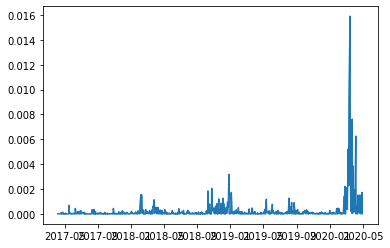

In [4]:
plt.plot(dataset[3086:])
plt.show()

# Shaping the data and creating Train and Test sets

Leveraging the work and code of Jason Brownlee (1).

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = dataset.values.reshape(-1,1)
dataset = scaler.fit_transform(dataset)

In [6]:
train_size = int(len(dataset) * 0.80)
val_size = int(len(dataset) * 0.10)
test_size = len(dataset) - train_size
train, val, test = dataset[0:(train_size - val_size),:], dataset[(train_size-val_size):train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(val), len(test))

2701 385 772


In [7]:
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [8]:
look_back = 5
trainX, trainY = create_dataset(train, look_back)
valX, valY = create_dataset(val, look_back)
testX, testY = create_dataset(test, look_back)

In [9]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
valX = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))

# Developing and Training the Dense Network
Leveraging Tensorflow (4)

In [10]:
# Using Keras to fit the Dense network
model = Sequential()
model.add(Dense(12, input_shape=(1,look_back), activation="sigmoid"))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(trainX, trainY, epochs=60, batch_size=1, validation_data = (valX, valY), verbose=1)

Train on 2695 samples, validate on 379 samples
Epoch 1/60
2695/2695 [==============================] - 2s 925us/sample - loss: 0.1245 - val_loss: 0.0232
Epoch 2/60
2695/2695 [==============================] - 2s 923us/sample - loss: 0.0105 - val_loss: 0.0039
Epoch 3/60
2695/2695 [==============================] - 3s 1ms/sample - loss: 0.0027 - val_loss: 8.0231e-04
Epoch 4/60
2695/2695 [==============================] - 3s 1ms/sample - loss: 0.0015 - val_loss: 2.5202e-04
Epoch 5/60
2695/2695 [==============================] - 3s 1ms/sample - loss: 0.0013 - val_loss: 1.5970e-04
Epoch 6/60
2695/2695 [==============================] - 3s 1ms/sample - loss: 0.0013 - val_loss: 1.4421e-04
Epoch 7/60
2695/2695 [==============================] - 3s 1ms/sample - loss: 0.0013 - val_loss: 1.4275e-04
Epoch 8/60
2695/2695 [==============================] - 3s 1ms/sample - loss: 0.0013 - val_loss: 1.4411e-04
Epoch 9/60
2695/2695 [==============================] - 3s 1ms/sample - loss: 0.0013 - val_lo

# Plotting the Train and Validation Loss Curve

Leveraging the works of Aurélien Géron (3)

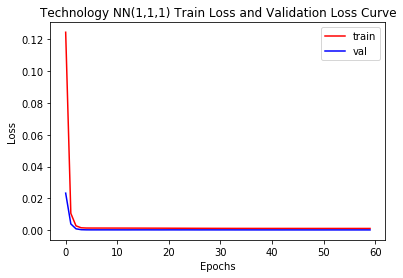

In [12]:
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title("{sector} NN(1,1,1) Train Loss and Validation Loss Curve".format(sector=sector))
    plt.legend(['train','val'],loc = 'upper right')
    #plt.savefig('Thesis Document\\KF5 Figures\\NN (5,1,1)\\' + sector + '\\' + sector + ' - NN(5,1,1) Train vs. Validation.png')
    plt.show()

train_error = history.history['loss']
val_error = history.history['val_loss']
plot_error(train_error,val_error)

# Results 

Continuing with the results from the Dense network predictions - Leveraging Jason Brownlee (1) and Aurélien Géron (3)

In [13]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = trainPredict.reshape((trainPredict.shape[0], trainPredict.shape[2]))
testPredict = testPredict.reshape((len(testPredict), 1))

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainMAE = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train MAE: %.7f' % (trainMAE))
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
trainMSE = trainScore**2
print('Train MSE: %.7f' % (trainMSE))
print('Train RMSE: %.7f' % (trainScore))

testMAE = mean_absolute_error(testY[0], testPredict[:,0])
print('Test MAE: %.7f' % (testMAE))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
testMSE = testScore**2
print('Test MSE: %.7f' % (testMSE))
print('Test RMSE: %.7f' % (testScore))


Train MAE: 0.0001850
Train MSE: 0.0000003
Train RMSE: 0.0005089
Test MAE: 0.0002387
Test MSE: 0.0000007
Test RMSE: 0.0008082


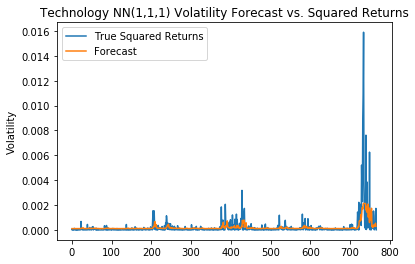

In [14]:
plt.plot(scaler.inverse_transform(test[look_back:]), label='True Squared Returns')
plt.plot(testPredict, label='Forecast')
plt.legend(loc='best')
plt.ylabel('Volatility')
plt.title("{sector} NN(1,1,1) Volatility Forecast vs. Squared Returns".format(sector=sector))
#plt.savefig('Thesis Document\\KF5 Figures\\NN (5,1,1)\\' + sector + '\\' + sector + ' - NN(5,1,1) Prediction.png')
plt.show()

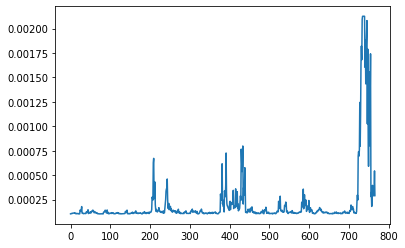

In [15]:
plt.plot(testPredict)
plt.show()

# References

(1) Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras - Jason Brownlee, PhD - https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/ - 2016

(2) Data Library - Kenneth R. French - https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html - 2020

(3) Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition - Aurélien Géron - https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ - 2019

(4) TensorFlow: Large-Scale Machine Learning on Heterogeneous Distributed Systems - https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/45166.pdf - 2015
